# Navigating a complex plume 

**Summary**: In this tutorial we simulate a complex plume, replay this plume in Mujoco and build a simple controller that can navigate it.


 We have shown in the [previous tutorial](https://neuromechfly.org/tutorials/olfaction.html) that our model is able to navigate a static odour field. In nature static odor fields are rather rare. On the contrary dynamic plumes (c.f illustration from [Demir et al, 2020](https://doi.org/10.7554/eLife.57524)) disclosing only short burst of odour represent a more naturalistic setting. In such an environment, the odour gradient carries only limited information regarding the position of the odour source. Consequently, navigating an odour plume requires the integration of multimodal sensory input (wind, odour). In this notebook we demonstrate how one can create a plume using [PhiFlow](https://tum-pbs.github.io/PhiFlow/) "a toolkit built for optimization and machine learning applications" used to solve the Navier-Stokes equation that determines the dynamics of our complex plume. We also show how such a recorded plume can be plugged into NeuroMechfly and finally we designed a very simple controller that can successfully navigate a complex plume.


<p align="center">
<img src="https://github.com/NeLy-EPFL/_media/blob/main/flygym/demir_et_al_real_odour_plume.jpg?raw=true" alt="complex plume" width="600"/>
 </p>
 

## Simulating a complex plume

To demonstrate the flexibility of our framework, we will simulate an arbitrary plume resembling the ones presented in [Demir et al. 2020]((https://doi.org/10.7554/eLife.57524)). Our plume is a modelled as a distinct specie embedded in an incompressible fluid. This is analogous to, for example, food odor being embedded in air. As such, we simulated the plume by solving the Navier—Stokes equations in 2D. Our simulation is initialized with a constant velocity field, producing a right-bound “wind”. On top of the wind we added random perturbations following a Brownian motion akin to lateral wind bursts making the flow turbulent and the plume more complex.

Any plume can be input in our model wether simulated or recorded. 

To work with the PhiFlow and generate your own plume make sure you have installed the "examples" requirements of flygym.

Let's decide on a few hyperparameters defining our plume. Here we define the size of the arena as well as the scaling factor for the velocity and smoke grid.
We can decide where to place the inflow and its size. 

In [1]:
# This notebook is partially based on the following script by  Felix Köhler:
# https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/phiflow/smoke_plume.py

import numpy as np
import h5py
from phi.torch import flow
from typing import Tuple
from tqdm import trange
from pathlib import Path

np.random.seed(0)
# change the simulation time to have a shorter simulation 
simulation_time = 20.0
dt = 0.1
arena_size = (80, 60)
inflow_pos = (4, 30)
inflow_radius = 1
inflow_scaler = 0.2
velocity_grid_size = 0.5
smoke_grid_size = 0.25
simulation_steps = int(simulation_time / dt)

Here we define in more details the dynamics of the plume.

In particular we load a helper function that outputs the borwnian contribution to the total wind at every timepoint.

```Python
def converging_brownian_step(
    value_curr: np.ndarray,
    center: np.ndarray,
    gaussian_scale: float = 1.0,
    convergence: float = 0.5,
) -> np.ndarray:
    """Step to simulate Brownian noise with convergence towards a center.

    Parameters
    ----------
    value_curr : np.ndarray
        Current value of variables (i.e., noise) in Brownian motion.
    center : np.ndarray
        Center towards which the Brownian motion converges.
    gaussian_scale : float, optional
        Standard deviation of Gaussian noise to be added to the current
        value, by default 1.0
    convergence : float, optional
        Factor of convergence towards the center, by default 0.5.

    Returns
    -------
    np.ndarray
        Next value of variables (i.e., noise) in Brownian motion.
    """
    gaussian_center = (center - value_curr) * convergence
    value_diff = np.random.normal(
        loc=gaussian_center, scale=gaussian_scale, size=value_curr.shape
    )
    value_next = value_curr + value_diff
    return value_next
```

In [2]:
from flygym.examples.olfaction.simulate_plume_dataset import converging_brownian_step

# Simulate Brownian noise and store the wind for every time step
curr_wind = np.zeros((2,))
wind_hist = [curr_wind.copy()]
for i in range(simulation_steps):
    curr_wind = converging_brownian_step(curr_wind, (0, 0), (1.2, 1.2), 1.0)
    wind_hist.append(curr_wind.copy())

# Define simulation grids
# constant velocity vector in every points
velocity = flow.StaggeredGrid(
    values=(10.0, 0.0),  # constant velocity field to the right
    extrapolation=flow.extrapolation.BOUNDARY,
    x=int(arena_size[0] / velocity_grid_size),
    y=int(arena_size[1] / velocity_grid_size),
    bounds=flow.Box(x=arena_size[0], y=arena_size[1]),
)

# choose extrapolation mode from
# ('undefined', 'zeros', 'boundary', 'periodic', 'symmetric', 'reflect')
# Zero smoke field at the beginning of the simulation
smoke = flow.CenteredGrid(
    values=0.0,
    extrapolation=flow.extrapolation.BOUNDARY,
    x=int(arena_size[0] / smoke_grid_size),
    y=int(arena_size[1] / smoke_grid_size),
    bounds=flow.Box(x=arena_size[0], y=arena_size[1]),
)

# Define inflow
inflow = inflow_scaler * flow.field.resample(
    flow.Sphere(x=inflow_pos[0], y=inflow_pos[1], radius=inflow_radius),
    to=smoke,
    soft=True,
)

/Users/stimpfli/anaconda3/envs/test/lib/python3.11/site-packages/phi/field/_field.py:142: FutureWarning: Instance checks on Grid are deprecated and will be removed in version 3.0. Use the methods instance.is_grid, instance.is_point_cloud, instance.is_centered and instance.is_staggered instead.
  return isinstance(self, Grid)
/Users/stimpfli/anaconda3/envs/test/lib/python3.11/site-packages/phi/field/_field.py:148: FutureWarning: Instance checks on PointCloud are deprecated and will be removed in version 3.0. Use the methods instance.is_grid, instance.is_point_cloud, instance.is_centered and instance.is_staggered instead.
  return isinstance(self, PointCloud)
/Users/stimpfli/anaconda3/envs/test/lib/python3.11/site-packages/phi/vis/_matplotlib/_matplotlib_plots.py:157: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


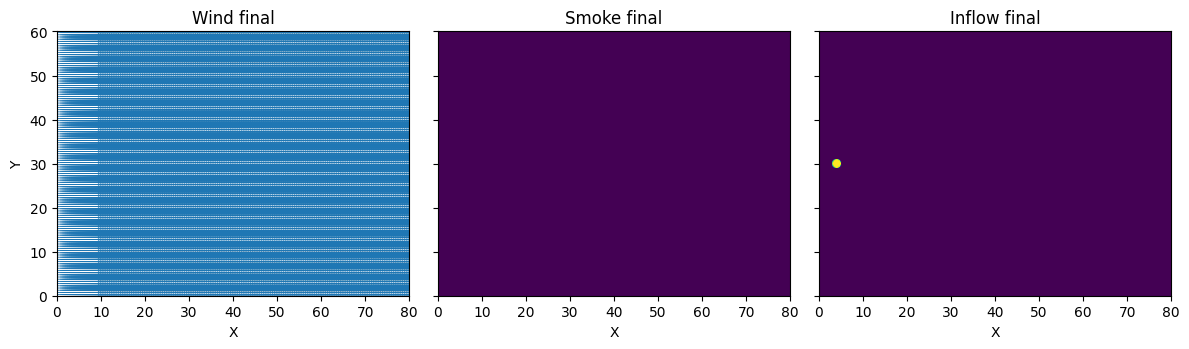

In [3]:
from phi import vis
vis.plot([velocity, smoke, inflow], title=["Wind final", "Smoke final", "Inflow final"], same_scale=False, show_color_bar=False)
vis.show()

Now we are ready to simulate the plume. For that we use the following step function:

```Python
def step(
    velocity_prev: flow.Grid,
    smoke_prev: flow.Grid,
    noise: np.ndarray,
    noise_magnitude: Tuple[float, float] = (0.1, 2),
    dt: float = 1.0,
    inflow: flow.Grid = None,
    ) -> Tuple[flow.Grid, flow.Grid]:
    """Simulate fluid dynamics by one time step.

    Parameters
    ----------
    velocity_prev : flow.Grid
        Velocity field at previous time step.
    smoke_prev : flow.Grid
        Smoke density at previous time step.
    noise : np.ndarray
        Brownian noise to be applied as external force.
    noise_magnitude : Tuple[float, float], optional
        Magnitude of noise to be applied as external force in x and y
        directions, by default (0.1, 2)
    dt : float, optional
        Simulation time step, by default 1.0

    Returns
    -------
    Tuple[flow.Grid, flow.Grid]
        Velocity field and smoke density at next time step.
    """
    smoke_next = flow.advect.mac_cormack(smoke_prev, velocity_prev, dt=dt) + inflow
    external_force = smoke_next * noise * noise_magnitude @ velocity_prev
    velocity_tentative = (
        flow.advect.semi_lagrangian(velocity_prev, velocity_prev, dt=dt)
        + external_force
    )
    velocity_next, pressure = flow.fluid.make_incompressible(velocity_tentative)
    return velocity_next, smoke_next
```

For every time step, we let the smoke advect in the velocity field and add new smoke through the inflow. Then the velocity field (composed of the previous wind and the brownian external noise) is self advected to ge the next velocity field and finally the pressures are projected using the make incompressible function. 
The step function will be repeated to unroll the full plume.

In [4]:
from flygym.examples.olfaction.simulate_plume_dataset import step

# Run fluid dynamics simulation
smoke_hist = []
for i in trange(simulation_steps):
    velocity, smoke = step(velocity, smoke, wind_hist[i], dt=dt, inflow=inflow, noise_magnitude=(1.0, 100.0))
    smoke_vals = smoke.values.numpy("y,x")
    smoke_hist.append(smoke_vals)

  0%|          | 0/200 [00:00<?, ?it/s]

/Users/stimpfli/anaconda3/envs/test/lib/python3.11/site-packages/phiml/backend/torch/_torch_backend.py:742: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  return torch.sparse_csr_tensor(row_pointers, column_indices, values, shape, device=values.device)
/Users/stimpfli/anaconda3/envs/test/lib/python3.11/site-packages/phiml/backend/torch/_torch_backend.py:60: TracerWarning: torch.from_numpy results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  tensor = torch.from_numpy(x)
/Users/stimpfli/anaconda3/envs/test/lib/pyt

In [18]:
# As our timesteps are big and we would like to preserve some temporal resolution, we interpolate the smoke field
# This is much faster than running the plume simulation with smaller timesteps and does the work for this example

from scipy.interpolate import interp1d

sim_timepoints = np.arange(0, simulation_time, step=dt)
smoke_hist_interp_fun = interp1d(
    sim_timepoints,
    smoke_hist,
    axis=0
)

new_timepoints = np.linspace(0, simulation_time-dt, num=10000)
smoke_hist_interp = smoke_hist_interp_fun(new_timepoints)

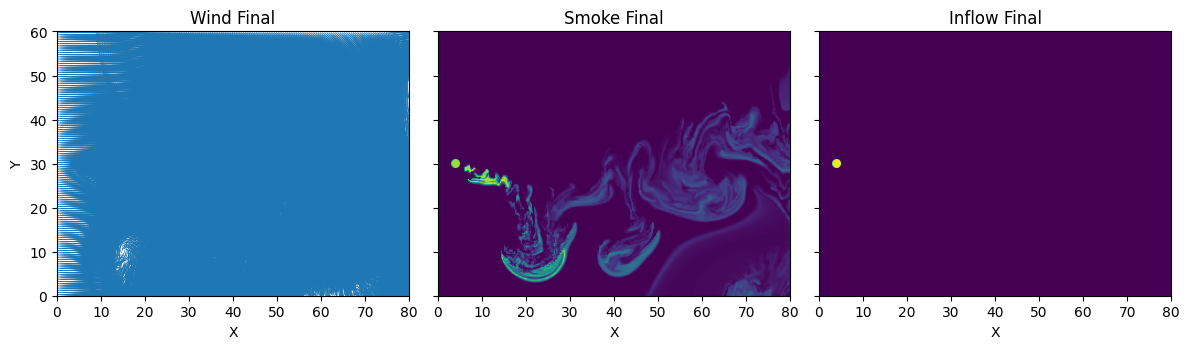

In [6]:
# show the velocity, smoke and inflow fields at the end of the simulation
vis.plot([velocity, smoke, inflow], title=["Wind Final", "Smoke Final", "Inflow Final"], same_scale=False, show_color_bar=False)
vis.show()

In [7]:
# making sure that the h5 file is not already open
for var_name in  ["arena", "fly", "sim", "cam"]:
    if var_name in locals():
        del locals()[var_name]

# save tge plume data for later use
plume_out_dir = Path("outputs/plume_navigation")
plume_out_dir.mkdir(exist_ok=True)
# Save plume simulation data
with h5py.File(plume_out_dir/"plume.hdf5", "w") as f:
    f["plume"] = np.stack(smoke_hist_interp).astype(np.float16)
    f["inflow_pos"] = inflow_pos
    f["inflow_radius"] = inflow_radius
    f["inflow_scaler"] = inflow_scaler

## Plume arena

Now we have to create an environment where the fly can navigate the plume. For sake of simplicity the pre-recorded plume is not physically interacting with the fly. When the fly is facing the plume we expect those perturbations to be minor anyways.

The OdourPlumeArena implements all the necessary functions to obtain sensory input from the plume and as well as resample the plume to the size of the arena.
Our simulated plume's original size is the same size as the biggest plume simulation grid. In our case it is the velocity grid. The plume simulation arena size is (80, 60) so the plume data has a physical size of (320, 240). That is why we scale it by a factor of 0.25 so that it has a more manageable size (final arena size (80, 60)).
Here we set a very high plume fps to reduce the number of steps to run and make the notebook overall faster to run.

Here is how those parameters are managed. 

``` Python 
class OdorPlumeArena(BaseArena):
    """
    This Arena class provides an interface to the separately simulated
    odor plume. The plume simulation is stored in an HDF5 file. In this
    class, we implement logics that calculate the intensity of the odor
    at the fly's location at the correct time.
    """
    def __init__(
            self,
            plume_data_path: Path,
            dimension_scale_factor: float = 0.5,
            plume_simulation_fps: float = 200,
            intensity_scale_factor: float = 1.0,
            friction: Tuple[float, float, float] = (1, 0.005, 0.0001),
            num_sensors: int = 4,
        ):
            """
            Parameters
            ----------
            plume_data_path : Path
                Path to the HDF5 file containing the plume simulation data.
            dimension_scale_factor : float, optional
                Scaling factor for the plume simulation grid. Each cell in the
                plume grid is this many millimeters in the simulation. By
                default 0.5.
            plume_simulation_fps : float, optional
                Frame rate of the plume simulation. Each frame in the plume
                dataset is ``1 / plume_simulation_fps`` seconds in the physics
                simulation. By default 200.
            intensity_scale_factor : float, optional
                Scaling factor for the intensity of the odor. By default 1.0.
            friction : Tuple[float, float, float], optional
                Friction parameters for the floor geom. By default (1, 0.005,
                0.0001).
            num_sensors : int, optional
                Number of olfactory sensors on the fly. By default 4.
            """

            super().__init__()

            self.dimension_scale_factor = dimension_scale_factor
            self.plume_simulation_fps = plume_simulation_fps
            self.intensity_scale_factor = intensity_scale_factor
            self.friction = friction
            self.num_sensors = num_sensors
            self.curr_time = 0
            self.plume_update_interval = 1 / plume_simulation_fps

            # Load plume data
            self.plume_dataset = h5py.File(plume_data_path, "r")
            self.plume_grid = self.plume_dataset["plume"]
            self.arena_size = (
                np.array(self.plume_grid.shape[1:][::-1]) * dimension_scale_factor
            )

            # Set up floor
            floor_material = self.root_element.asset.add(
                "material",
                name="floor_material",
                reflectance=0.0,
                shininess=0.0,
                specular=0.0,
                rgba=[0.6, 0.6, 0.6, 1],
            )
            self.root_element.worldbody.add(
                "geom",
                name="floor",
                type="box",
                size=(self.arena_size[0] / 2, self.arena_size[1], 1),
                pos=(self.arena_size[0] / 2, self.arena_size[1] / 2, -1),
                material=floor_material,
            )

            # Add birdeye camera
            self.birdeye_cam = self.root_element.worldbody.add(
                "camera",
                name="birdeye_cam",
                mode="fixed",
                pos=(
                    0.50 * self.arena_size[0],
                    0.15 * self.arena_size[1],
                    1.00 * self.arena_size[1],
                ),
                euler=(np.deg2rad(15), 0, 0),
                fovy=60,
            )
```

The inits adds a camera to the arena that gives an immobile birds-eye view. 
the class provides a function to get the olfaction intensity for every sensor:

```Python 
def get_olfaction(self, antennae_pos: np.ndarray) -> np.ndarray:
        """
        Returns the olfactory input for the given antennae positions. If
        the fly is outside the plume simulation grid, returns np.nan.
        """
        # get the current frame of the plume
        frame_num = int(self.curr_time * self.plume_simulation_fps)
        assert self.num_sensors == antennae_pos.shape[0]
        intensities = np.zeros((self.odor_dimensions, self.num_sensors))
        for i_sensor in range(self.num_sensors):
            # get the sensor position in mm (from the physics)
            x_mm, y_mm, _ = antennae_pos[i_sensor, :]
            # map to our simulated plume dimensions
            x_idx = int(x_mm / self.dimension_scale_factor)
            y_idx = int(y_mm / self.dimension_scale_factor)
            if (
                x_idx < 0
                or y_idx < 0
                or x_idx >= self.plume_grid.shape[2]
                or y_idx >= self.plume_grid.shape[1]
            ):
                intensities[0, i_sensor] = np.nan
            else:
                intensities[0, i_sensor] = self.plume_grid[frame_num, y_idx, x_idx]
        return intensities * self.intensity_scale_factor
```

The class finally provides a function to get the position mapping between the birdeye camera and the simulated plume grid. This will reveal very handy when wanting to project the simulated plume on the arena for proper rendering.
 
``` Python
def get_position_mapping(
        self, sim: Simulation, camera_id: str = "birdeye_cam"
    ) -> np.ndarray:
        """Get the display location (row-col coordinates) of each pixel on
        the fluid dynamics simulation.

        Parameters
        ----------
        sim : Simulation
            Simulation simulation object.
        camera_id : str, optional
            Camera to build position mapping for, by default "birdeye_cam"

        Returns
        -------
        pos_display: np.ndarray
            Array of shape (n_row_pxls_plume, n_col_pxls_plume, 2)
            containing the row-col coordinates of each plume simulation
            cell on the **display** image (in pixels).
        pos_physical: np.ndarray
            Array of shape (n_row_pxls_plume, n_col_pxls_plume, 2)
            containing the row-col coordinates of each plume simulation
            cell on the **physical** simulated grid (in mm). This is a
            regular lattice grid marking the physical position of the
            *centers* of the fluid simulation cells.
        """
        birdeye_cam_dm_control_obj = Camera(
            sim.physics,
            camera_id=camera_id,
            width=sim.cameras[0].window_size[0],
            height=sim.cameras[0].window_size[1],
        )
        camera_matrix = birdeye_cam_dm_control_obj.matrix
        # Get the center of every grid cell
        xs_physical, ys_physical = np.meshgrid(
            np.arange(self.arena_size[0]) + 0.5,
            np.arange(self.arena_size[1]) + 0.5,
        )
        # project those centers to the camera coordinates
        xyz1_vecs = np.ones((xs_physical.size, 4))
        xyz1_vecs[:, 0] = xs_physical.flatten()
        xyz1_vecs[:, 1] = ys_physical.flatten()
        xyz1_vecs[:, 2] = 0
        pos_physical = xyz1_vecs[:, :2].reshape(*xs_physical.shape, 2)
        xs_display, ys_display, display_scale = camera_matrix @ xyz1_vecs.T
        xs_display /= display_scale
        ys_display /= display_scale
        pos_display = np.vstack((xs_display, ys_display))
        pos_display = pos_display.T.reshape(*xs_physical.shape, 2)
        return pos_display, pos_physical

```


In [8]:
from flygym.examples.olfaction.plume_tracking_arena import OdorPlumeArena

arena = OdorPlumeArena(plume_out_dir/"plume.hdf5", plume_simulation_fps=8000, dimension_scale_factor=0.25)

Here is a short example showing how the odour intensity readouts change as a function of time

In [9]:
from flygym import Fly, SingleFlySimulation, Camera
from flygym.examples.common import PreprogrammedSteps

timestep = 1e-4
run_time = 1.0

# init fly simultion 
fly = Fly(enable_olfaction=True,
          spawn_pos=(60.0, 30.0, 0.25),
        spawn_orientation=(0, 0, -np.pi / 2),
)
sim = SingleFlySimulation(fly=fly, arena=arena, cameras=[])

preprogrammed_step = PreprogrammedSteps()
standing_joint_angles = []

for leg in preprogrammed_step.legs:
    standing_joint_angles.extend(
        preprogrammed_step.get_joint_angles(leg, 0.0)
        )

target_num_steps = int(run_time / timestep)
obs_list = []

for i in trange(target_num_steps):
    (obs, reward, terminated,
    truncated, info) = sim.step(action={
        "joints": standing_joint_angles
        })

    obs_list.append(obs)

100%|██████████| 10000/10000 [00:18<00:00, 534.40it/s]


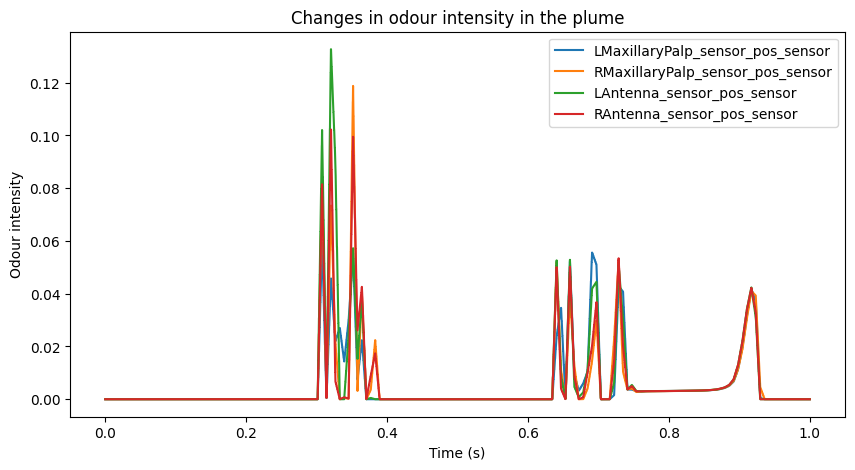

In [10]:
import matplotlib.pyplot as plt

odour_intensities = np.array([obs["odor_intensity"] for obs in obs_list])
time = np.arange(0, run_time, timestep)

plt.figure(figsize=(10, 5))

lines = plt.plot(time, odour_intensities.squeeze())
plt.xlabel("Time (s)")
plt.ylabel("Odour intensity")
plt.title("Changes in odour intensity in the plume")

plt.legend(lines, [sensor.name for sensor in fly._antennae_sensors])
plt.show()

## Plume tracking task

Now that we can have an arena and track the changes in the fly's sensed odour we might want to display the plume on the fly. The rendering is handled by the simulation. We build a PlumeNavigationTask simulation that takes care of the rendering.

Let's just define a fly, an arena and a camera to start with.

In [11]:
arena = OdorPlumeArena(plume_out_dir/"plume.hdf5", plume_simulation_fps=8000, dimension_scale_factor=0.25)

# Define the fly
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

fly = Fly(
        enable_adhesion=True,
        draw_adhesion=True,
        enable_olfaction=True,
        enable_vision=False,
        contact_sensor_placements=contact_sensor_placements,
        spawn_pos=(60.0, 30.0, 0.25),
        spawn_orientation=(0, 0, -np.pi / 2),
    )
cam = Camera(fly=fly, camera_id="birdeye_cam",
            play_speed=0.2,
            timestamp_text=True)

Now we are going to dive deeper into the PlumeNavigationTask. Here are the set of paramerters of this class.

```Python 
class PlumeNavigationTask(HybridTurningController):
    """
    A wrapper around the ``HybridTurningController`` that implements logics
    and utilities related to plume tracking such as overlaying the plume on
    the rendered images. It also checks if the fly is within the plume
    simulation grid and truncates the simulation accordingly.
    """

    def __init__(
        self,
        render_plume_alpha: float = 0.75,
        intensity_display_vmax: float = 1.0,
        **kwargs,
    ):
        """
        Parameters
        ----------
        render_plume_alpha : float
            The transparency of the plume overlay on the rendered images.
        intensity_display_vmax : float
            The maximum intensity value to be displayed on the rendered
            images.
        """

        super().__init__(**kwargs)
        self.arena: OdorPlumeArena = kwargs["arena"]
        self._plume_last_update_time = -np.inf
        self._cached_plume_img = None
        self._render_plume_alpha = render_plume_alpha
        self._intensity_display_vmax = intensity_display_vmax
```

Now we will define the transformation from the simulated plume space to the camera space.
For that, we first compute the transformation from the physical space to the camera space.

``` Python 
    # Find out where on the displayed images the plume simulation grid
    # should be overlaid. In other words, interpolate the mapping from
    # displayed pixel position to simulated physical position.
    pos_display_sample, pos_physical_sample = self.arena.get_position_mapping(
        self, camera_id="birdeye_cam"
    )
```
Get the indices in the physical plume that matches the pixel locations
``` Python
    pos_display_sample = pos_display_sample.reshape(-1, 2)
    pos_physical_sample = pos_physical_sample.reshape(-1, 2)
    interp = LinearNDInterpolator(
        pos_display_sample, pos_physical_sample, fill_value=np.nan
    )
    xs_display, ys_display = np.meshgrid(
        np.arange(self.cameras[0].window_size[0]),
        np.arange(self.cameras[0].window_size[1]),
    )
    pos_display_all = np.vstack([xs_display.flatten(), ys_display.flatten()]).T
    pos_physical_all = interp(pos_display_all)
    pos_physical_all = pos_physical_all.reshape(
        *self.cameras[0].window_size[::-1], 2
    )
    grid_idx_all = pos_physical_all / self.arena.dimension_scale_factor
    grid_idx_all[np.isnan(grid_idx_all)] = -1
    # self.grid_idx_all has the shape (cam_nrows, cam_ncols, 2) and
    # indicates the (x, y) indices of the plume simulation grid cell.
    # When the index is -1, this point on the displayed image is out of
    # the simulated arena.
    self.grid_idx_all = grid_idx_all.astype(np.int16)
```
In the render function we now just need to get the image corresponding to the actual timepoint and overlay it on top of the camera image. We also add a mean intensity at the bottom for visualization.

```Python
def render(self, *args, **kwargs):
    rendered_img = super().render(*args, **kwargs)[0]
    if rendered_img is None:
        return [rendered_img]  # no image rendered

    # Overlay plume
    time_since_last_update = self.curr_time - self._plume_last_update_time
    update_needed = time_since_last_update > self.arena.plume_update_interval
    if update_needed or self._cached_plume_img is None:
        t_idx = int(self.curr_time * self.arena.plume_simulation_fps)
        self._cached_plume_img = _resample_plume_image(
            self.grid_idx_all, self.arena.plume_grid[t_idx, :, :].astype(np.float32)
        )
        self._plume_last_update_time = self.curr_time
    plume_img = self._cached_plume_img[:, :, np.newaxis] * self._render_plume_alpha
    plume_img[np.isnan(plume_img)] = 0
    rendered_img = np.clip(rendered_img - plume_img * 255, 0, 255).astype(np.uint8)

    # Add intensity indicator
    mean_intensity = self.get_observation()["odor_intensity"].mean()
    mean_intensity_relative = np.clip(
        mean_intensity / self._intensity_display_vmax, 0, 1
    )
    rmin = self.cameras[0].window_size[1] - 10
    rmax = self.cameras[0].window_size[1]
    cmin = 0
    cmax = int(self.cameras[0].window_size[0] * mean_intensity_relative)
    rendered_img[rmin:rmax, cmin:cmax] = (255, 0, 0)

    # Replace recorded image with modified one
    self.cameras[0]._frames[-1] = rendered_img
    return [rendered_img]
```

With the resample plume function being: 
``` Python 
def _resample_plume_image(grid_idx_all, plume_grid):
    plume_img = np.zeros(grid_idx_all.shape[:2])
    for i in prange(grid_idx_all.shape[0]):
        for j in prange(grid_idx_all.shape[1]):
            x_idx = grid_idx_all[i, j, 0]
            y_idx = grid_idx_all[i, j, 1]
            if x_idx != -1:
                plume_img[i, j] = plume_grid[y_idx, x_idx]
    return plume_img
```

In [12]:
from flygym.examples.olfaction.plume_tracking_task import PlumeNavigationTask

sim = PlumeNavigationTask(
    fly=fly,
    arena=arena,
    cameras=[cam],
)

In [13]:
# Run the simulation and save the video
sim.reset(0)

straight_dn_drive = np.array([1.0, 1.0])
for i in trange(target_num_steps):
    obs, reward, terminated, truncated, info = sim.step(straight_dn_drive)
    sim.render()

cam.save_video(plume_out_dir/"plume_display.mp4")

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:28<00:00, 352.84it/s]


## Simple controller

Lets build a simple plume navigation controller. We propose a model that walks crosswind when little odour evidence was accumulated and upwind when encountering a lot of odour packets. The crosswind direction is random and biased by the encounter history during crosswind walks.

As in the first frames of the plume simulation, the plume just reaches the other half of the arena we cropped the beginning of the plume simulation. This helps reducing the number of simulated time steps. 

In [14]:
time_cropped_plume = smoke_hist_interp[1000:]

# lets crop a few frames from the plume simulation
with h5py.File(plume_out_dir/"plume_tcropped.hdf5", "w") as f:
    f["plume"] = np.stack(time_cropped_plume).astype(np.float16)
    f["inflow_pos"] = inflow_pos
    f["inflow_radius"] = inflow_radius
    f["inflow_scaler"] = inflow_scaler


Here is defined the class implementing the simple controller. 
Our controller accumulates odour evidence during a fixed interval of time. The accumulated evidences increases with odour encounter and decreases linearly with time. From the accumulated evidence, we derive an angle to the wind direction. The more evidences are accumulated, the more upwind the fly heads while it heads more crosswind when no evidences are accumulated. When the target angle is defined, the descending drive is regularly updated to match the target angle. 

In [15]:
from enum import Enum
import cv2
from flygym.util import get_data_path

class WalkingState(Enum):
    FORWARD = 0
    TURN_LEFT = 1
    TURN_RIGHT = 2
    STOP = 3

# get the angle of the vector in world coordinates
def get_vector_angle(v):
    return np.arctan2(v[1], v[0])

# change an array to a set of probabilities (sum to 1)
# this is used to bias the crosswind walk
def to_probability(x):
    # the difference between the two values reflects
    # the probability of each entry
    x += np.abs(np.min(x)) + 1
    return x/np.sum(x)

class SimplePlumeNavigationController:
    # defines a very simple controller to navigate the plume
    def __init__(self, timestep, wind_dir=[-1.0, 0.0], seed=0):
        self.timestep = timestep
        self.wind_dir = wind_dir

        np.random.seed(seed)
        
        # define the dn drives for each state
        self.dn_drives = {
            WalkingState.FORWARD: np.array([1.0, 1.0]),
            WalkingState.TURN_LEFT: np.array((-0.4, 1.2)),
            WalkingState.TURN_RIGHT: np.array((1.2, -0.4)),
            WalkingState.STOP: np.array((0.0, 0.0)),
        }

        # evidence acccumulation parameters
        self.accumulated_evidence = 0.0
        self.accumulation_decay = 0.0001
        self.accumulation_odour_gain = 0.05
        self.accumulation_threshold = 20.0

        # decision making parameters
        self.default_decision_interval = 0.75#s
        self.since_last_decision_time = 0.0

        # minimal evidence value during a decision interval
        self.min_evidence = -1 * self.accumulation_decay*self.default_decision_interval/timestep

        # dn drive parameters
        self.dn_drive_update_inteval = 0.1#s
        self.dn_drive_update_steps = int(self.dn_drive_update_inteval/self.timestep)
        self.dn_drive = self.dn_drives[WalkingState.STOP]

        # controller state parameters
        self.curr_state = WalkingState.STOP
        self.target_angle = np.nan
        self.to_upwind_angle = np.nan
        self.upwind_success = [0, 0]
        
        # boundary checking parameters
        self.boundary_refractory_period = 1.0
        self.boundary_time = 0.0

    def get_target_angle(self):
        """
        Get the target angle to the wind based on the accumulated evidence, the wind direction
        and the history of success in the crosswind direction
        The target angle is more upwind if the accumulated evidence is high
        and more crosswind if the accumulated evidence is low

        Returns
        -------
        target_angle : float
            The target angle to the wind (in radian)
        to_upwind_angle : float
            The angle to the upwind direction (in radian)
        """
        
        up_wind_angle = get_vector_angle(self.wind_dir) - np.pi
        # the angle to the wind is defined by the accumlated evidence:
        #     -if little evidence, the fly will go crosswind (angle to upwind = np.pi/2)
        #     -if a lot of evidence, the fly will go upwind (angle to upwind = 0)
        to_upwind_angle = np.tanh(self.accumulated_evidence)*np.pi/4 - np.pi/4
        crosswind_success_proba = to_probability(self.upwind_success)   

        # make random the sign of the angle depending on the history of success
        to_upwind_angle = np.random.choice([-1, 1], p=crosswind_success_proba) * np.abs(to_upwind_angle)
        
        # compute the target angle (the up wind angle + the angle to upwind direction)
        target_angle = up_wind_angle + to_upwind_angle
        if target_angle > np.pi:
            target_angle -= 2*np.pi
        elif target_angle < -np.pi:
            target_angle += 2*np.pi

        return target_angle, to_upwind_angle

    def angle_to_dn_drive(self, fly_orientation):
        """
        Compare the fly orientation to the target angle and return the
        dn drive that will make the fly go in the right direction

        Parameters
        ----------
        fly_orientation : np.array
            The fly orientation vector

        Returns
        -------
        dn_drive : np.array
            The dn drive that will make the fly go in the right direction
        """

        fly_angle = get_vector_angle(fly_orientation)
        angle_diff = self.target_angle - fly_angle
        if angle_diff > np.pi:
            angle_diff -= 2*np.pi
        elif angle_diff < -np.pi:
            angle_diff += 2*np.pi

        if np.isnan(self.target_angle):
            return self.dn_drives[WalkingState.STOP], WalkingState.STOP
        elif angle_diff > np.deg2rad(10):
            return self.dn_drives[WalkingState.TURN_LEFT], WalkingState.TURN_LEFT
        elif angle_diff < -np.deg2rad(10):
            return self.dn_drives[WalkingState.TURN_RIGHT], WalkingState.TURN_RIGHT
        else:
            return self.dn_drives[WalkingState.FORWARD], WalkingState.FORWARD
    
    def step(self, fly_orientation, odour_intensities,
             close_to_boundary, curr_time):
        
        """
        Step the controller:
            - Check if the fly is close to the boundary
            - Accumulate evidence
            - Update the target angle if:
                - the accumulated evidence is high
                - the decision interval is reached
                - the fly is close to the boundary
            - Update the sucess history:
                - If crosswind: update the success history (increases if
                  the fly collected evidence in that direction, decreases otherwise)
                - If close to boundary and the fly is not upwind: decrease the success history
            - Update the dn drive
            - Increment time and counters

        Parameters
        ----------
        fly_orientation : np.array
            The fly orientation vector
        odour_intensities : np.array
            The odour intensities collected by the fly
        close_to_boundary : bool    
            Whether the fly is close to the boundary
        curr_time : float
            The current time of the simulation

        Returns
        -------
        dn_drive : np.array
            The dn drive that will make the fly go in the right direction
        """
        
        if self.boundary_time > 0.0:
            self.boundary_time += self.timestep
        elif self.boundary_time > self.boundary_refractory_period:
            self.boundary_time = 0.0
        
        boundary_inv =  close_to_boundary and self.boundary_time == 0.0

        if (self.accumulated_evidence > self.accumulation_threshold or 
            self.since_last_decision_time > self.default_decision_interval or
            boundary_inv):

            if self.accumulated_evidence > self.accumulation_threshold:
                # reset the history and just take into account the last success
                self.upwind_success = [0, 0]

            if boundary_inv:
                # if close to the boundary and not upwind
                # decrease the success history of the currect directions as it led the
                # fly to the boundary
                if self.to_upwind_angle < np.deg2rad(-45):
                    self.upwind_success[0] -= 10
                elif self.to_upwind_angle > np.deg2rad(45):
                    self.upwind_success[1] -= 10
                self.boundary_time += self.timestep
            else:
                # else update the success history if crosswind and
                # the fly collected evidence in that direction
                # increase the success history 
                if self.to_upwind_angle < np.deg2rad(-45):
                    self.upwind_success[0] += 1 if self.accumulated_evidence > self.min_evidence else -1
                elif self.to_upwind_angle > np.deg2rad(45):
                    self.upwind_success[1] += 1 if self.accumulated_evidence > self.min_evidence else -1

            # reset counters
            self.target_angle, self.to_upwind_angle = self.get_target_angle()
            self.accumulated_evidence = 0.0
            self.since_last_decision_time = 0.0
        else:
            # update the accumulated evidence
            self.accumulated_evidence += \
                odour_intensities.sum()*self.accumulation_odour_gain - \
                    self.accumulation_decay
        if np.rint(curr_time/self.timestep) % self.dn_drive_update_steps == 0 or boundary_inv:
            # §update the dn drive
            self.dn_drive, self.curr_state = self.angle_to_dn_drive(fly_orientation)

        self.since_last_decision_time += self.timestep

        return self.dn_drive
    
    def reset(self, seed=0):
        """
        Reset all the counters and parameters of the controller

        Parameters
        ----------
        seed : int
            The random seed to use for the controller

        Returns
        -------
        None
        """
        np.random.seed(seed)
        self.accumulated_evidence = 0.0
        self.since_last_decision_time = 0.0
        self.upwind_success = [0, 0]
        self.boundary_time = 0.0
        self.target_angle = np.nan
        self.to_upwind_angle = np.nan
        self.curr_state = WalkingState.STOP
        self.dn_drive = self.dn_drives[self.curr_state]
        

def get_debug_str(accumulated_evidence, curr_angle, target_angle, crosswind_success_proba):
    """
    Get a string that represents the state of the controller
    """
    crosswind_success_proba_str = " ".join([f"{co:.2f}" for co in crosswind_success_proba])
    return [f"Accumulated evidence: {accumulated_evidence:.2f}",
            f"Fly orientation: {np.rad2deg(curr_angle):.2f}",
            f"Target angle: {np.rad2deg(target_angle):.2f}",
            f"Crosswind success proba: {crosswind_success_proba_str}"]


def get_walking_icons():
    """
    Get all icons representing the walking directions
    """
    icons_dir = get_data_path("flygym", "data") / "etc/locomotion_icons"
    icons = {}
    for key in ["forward", "left", "right", "stop"]:
        icon_path = icons_dir / f"{key}.png"
        icons[key] = cv2.imread(str(icon_path), cv2.IMREAD_UNCHANGED)
    return {
        WalkingState.FORWARD: icons["forward"],
        WalkingState.TURN_LEFT: icons["left"],
        WalkingState.TURN_RIGHT: icons["right"],
        WalkingState.STOP: icons["stop"],
    }

def get_inflow_circle(inflow_pos, inflow_radius, camera_matrix):
    """
    Compute the xy locations of the inflow circle in the camera view
    """
    # draw a circle arround the inflow position (get x y pos of
    # a few points on the circle)
    circle_x, circle_y = [], []
    for angle in np.linspace(0, 2*np.pi+0.01, num=50):
        circle_x.append(inflow_pos[0] + inflow_radius*np.cos(angle))
        circle_y.append(inflow_pos[1] + inflow_radius*np.sin(angle))

    xyz_global = np.array([circle_x, circle_y, np.zeros_like(circle_x)])

    # project those points on the camera view
    # Camera matrices multiply homogenous [x, y, z, 1] vectors.
    corners_homogeneous = np.ones((4, xyz_global.shape[1]), dtype=float)
    corners_homogeneous[:3, :] = xyz_global

    # Project world coordinates into pixel space. See:
    # https://en.wikipedia.org/wiki/3D_projection#Mathematical_formula
    xs, ys, s = camera_matrix @ corners_homogeneous

    # x and y are in the pixel coordinate system.
    x = np.rint(xs / s).astype(int)
    y = np.rint(ys / s).astype(int)

    return x, y


def render_overlay(rendered_img, accumulated_evidence,
                   fly_orientation, target_angle,
                   crosswind_success_proba, icon,
                   window_size, inflow_x, inflow_y):
    
    """
    Helper function to modify the simulation rendered images
    """
    
    if rendered_img is not None:
        sub_strings = get_debug_str(accumulated_evidence, get_vector_angle(fly_orientation),
                                    target_angle, crosswind_success_proba)
        # put string at the top left corner of the image
        for j, sub_string in enumerate(sub_strings):
            rendered_img = cv2.putText(rendered_img, sub_string,
                                    (5, window_size[1]-(len(sub_strings)-j+1)*15),
                                    cv2.FONT_HERSHEY_SIMPLEX,
                                    0.4, (0, 0, 0), 1, cv2.LINE_AA)
        # put the icon just under the debug string
        rendered_img[
            window_size[1]-100-icon.shape[1]:window_size[1]-100,
            0:icon.shape[1],
            :
            ] = icon
        
        # draw the inflow circle as a free line
        rendered_img = cv2.polylines(
            rendered_img,
            [np.array([list(zip(inflow_x, inflow_y))])],
            isClosed=True,
            color=(255, 0, 0),
            thickness=2
        )
        
    return rendered_img

def is_close_to_boundary(pos, arena_size, margin=5.0):
    """
    Check if the fly is close to the boundary
    
    """
    return (pos[0] < margin or pos[0] > arena_size[0]-margin or
            pos[1] < margin or pos[1] > arena_size[1]-margin)


Now lets run this controller

In [16]:
from dm_control.mujoco import Camera as DmCamera

# write the same loop as before but with the new controller
timestep = 1e-4
run_time = 10.0

np.random.seed(0)
arena = OdorPlumeArena(plume_out_dir/"plume_tcropped.hdf5", plume_simulation_fps=800, dimension_scale_factor=0.25)

# Define the fly
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

fly = Fly(
        enable_adhesion=True,
        draw_adhesion=True,
        enable_olfaction=True,
        enable_vision=False,
        contact_sensor_placements=contact_sensor_placements,
        # Here the opposite spawn position can be tried (65.0, 15.0, 0.25)
        spawn_pos=(65.0, 45.0, 0.25),
        spawn_orientation=(0, 0, -np.pi / 2),
    )

wind_dir = [1.0, 0.0]
ctrl = SimplePlumeNavigationController(timestep, wind_dir=wind_dir)

cam = Camera(fly=fly, camera_id="birdeye_cam",
            play_speed=0.5,
            timestamp_text=True)

dm_cam = DmCamera(
    sim.physics,
    camera_id=cam.camera_id,
    width=cam.window_size[0],
    height=cam.window_size[1],
)
camera_matrix = dm_cam.matrix
arena_inflow_pos = np.array(inflow_pos)/arena.dimension_scale_factor*smoke_grid_size
target_inflow_radius = 5.0
inflow_x, inflow_y = get_inflow_circle(
    arena_inflow_pos,
    target_inflow_radius,
    camera_matrix,
)

sim = PlumeNavigationTask(
    fly=fly,
    arena=arena,
    cameras=[cam],
)

walking_icons = get_walking_icons()

obs, info = sim.reset(0)

for i in trange(np.rint(run_time/timestep).astype(int)):
    fly_orientation = obs["fly_orientation"][:2]
    fly_orientation /= np.linalg.norm(fly_orientation)
    close_to_boundary = is_close_to_boundary(obs["fly"][0][:2], arena.arena_size)
    dn_drive = ctrl.step(fly_orientation, obs["odor_intensity"],
                         close_to_boundary, sim.curr_time)
    
    obs, reward, terminated, truncated, info = sim.step(dn_drive)

    icon = walking_icons[ctrl.curr_state][:, :, :3]
    rendered_img = sim.render()[0]
    rendered_img = render_overlay(rendered_img, ctrl.accumulated_evidence,
                                    fly_orientation, ctrl.target_angle,
                                    to_probability(ctrl.upwind_success),
                                    icon, cam.window_size,
                                    inflow_x, inflow_y)
    
    if rendered_img is not None:
        cam._frames[-1] = rendered_img
    

    if np.linalg.norm(obs["fly"][0][:2]-arena_inflow_pos) < target_inflow_radius:
        print("The fly reached the inflow")
        break
    elif truncated:
        print("The fly went out of bound")
        break

    obs_list.append(obs)

 70%|██████▉   | 69942/100000 [03:11<01:22, 365.48it/s]

The fly reached the inflow


In [17]:
cam.save_video(plume_out_dir/"plume_navigation_controller.mp4")